# Prediction on yellow fever simulated reads (no storage)

This is a a reference notebook for prediction inference on yellow fever simulated reads, using the CNN_Virus original model and saving predictions, probabilities and metadata in a sqlite database.

- Simulated reads from an aligned file generated by ART Illumina simulator (`*.aln file`).
- Uses the dataset class `AlnFileDataset` to read batches of simulated reads and their metadata.
- Uses the `cnn_virus` model to predict the label and position probabilities and classes for each simreads.
- Creates a prediction report save data for analysis.

> **Note**: 
>
> When an `*.aln` file counts a very large number of simulated reads, running a prediction on all of them is very time consuming. Therefore, we also provide a function `skip_existing_predictions` applied to the generator, which allows to skip all simulated reads down to the last simulated read for which a prediction was already saved into the database. This allows to build the database step by step.

# 1. Imports and setup environment

In [1]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('eccore'):
    print('installing package: `eccore`')
    ! pip install -qqU eccore
else:
    print('`eccore` already installed')
if not importlib.util.find_spec('metagentorch'):
    print('installing package: `metagentorch')
    ! pip install -qqU metagentorch
else:
    print('`metagentorch` already installed')

`eccore` already installed
`metagentorch` already installed


In [2]:
# Import all required packages
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import shutil
import time

from datetime import datetime
from eccore.core import files_in_tree
from eccore.ipython import nb_setup
from functools import partial
from nbdev import show_doc
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Any, Generator

# Setup the notebook for development
nb_setup()

os.environ['KERAS_BACKEND'] = "torch"
import torch
from torch.utils.data import DataLoader
import keras

from metagentorch.cnn_virus.data import AlnFileDataset
from metagentorch.cnn_virus.data import combine_prediction_batch
from metagentorch.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader
from metagentorch.cnn_virus.data import OriginalLabels
from metagentorch.cnn_virus.architecture import create_model_original
from metagentorch.core import ProjectFileSystem, list_available_devices

Set autoreload mode


List all computing devices available on the machine

In [3]:
list_available_devices()

CUDA available: True
Number of CUDA devices: 1
CUDA Device 0: NVIDIA GeForce GTX 1050
CPU available: cpu


# 2. Setup paths to files

Key folders and system information

In [4]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentorch 
 - Data Dir .... /home/vtec/projects/bio/metagentorch/data 
 - Notebooks ... /home/vtec/projects/bio/metagentorch/nbs


- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model

In [5]:
p2model = pfs.data / 'saved/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

p2virus_labels = pfs.data / 'CNN_Virus_data/virus_name_mapping'
assert p2virus_labels.is_file(), f"No file found at {p2virus_labels.absolute()}"

Path to the simulated read we want to use

In [6]:
fnames = files_in_tree(pfs.data / 'ncbi/simreads/yf', pattern='69seq')

simreads
  |--yf
  |    |--single_69seq_150bp
  |    |    |--single_69seq_150bp.fq (0)
  |    |    |--single_69seq_150bp.aln (1)
  |    |    |--single_69seq_150bp_list_reads.json (2)


In [7]:
file_stem = 'single_69seq_150bp'

p2aln = pfs.data / f"ncbi/simreads/yf/{file_stem[:-2] if file_stem[-1] in ['1', '2'] else file_stem}/{file_stem}.aln"
assert p2aln.exists()

aln = AlnFileReader(p2aln)
print(f"Reading alignment file: {p2aln.name}:\n")
for i, aln_read in enumerate(aln):
    pass
print(f"  - {i+1:,d} simulated reads in file '{p2aln.name}' from {len(aln.header['reference sequences'])} reference sequences.")

print('  - ART command: ',aln.header['command'])
print('  - Reference Sequences:')
print('     ','\n      '.join(aln.header['reference sequences']))

Reading alignment file: single_69seq_150bp.aln:

  - 1,160,343 simulated reads in file 'single_69seq_150bp.aln' from 69 reference sequences.
  - ART command:  /usr/bin/art_illumina -i /home/vtec/projects/bio/metagentools/data/ncbi/refsequences/yf/yf_2023_yellow_fever.fa -ss HS25 -l 150 -f 250 -o /home/vtec/projects/bio/metagentools/data/ncbi/simreads/yf/single_69seq_150bp/single_69seq_150bp -rs 1731415434
  - Reference Sequences:
      @SQ	11089:ncbi:1	1	AY968064	11089	ncbi	Angola_1971	10234
      @SQ	11089:ncbi:2	2	U54798	11089	ncbi	Ivory_Coast_1982	10231
      @SQ	11089:ncbi:3	3	DQ235229	11089	ncbi	Ethiopia_1961	10234
      @SQ	11089:ncbi:4	4	AY572535	11089	ncbi	Gambia_2001	10231
      @SQ	11089:ncbi:5	5	MF405338	11089	ncbi	Ghana_Hsapiens_1927	10231
      @SQ	11089:ncbi:6	6	U21056	11089	ncbi	Senegal_1927	10231
      @SQ	11089:ncbi:7	7	AY968065	11089	ncbi	Uganda_1948	10234
      @SQ	11089:ncbi:8	8	JX898871	11089	ncbi	ArD114896_Senegal_1995	10231
      @SQ	11089:ncbi:9	9	JX898872	11089

# 3. (Optional) Test each inference step

Let's test each step to prepare model inputs, generate the prediction and all calculated metrics, using a small batch size:
1. create the dataloader to load reads, label and positions, as well as metadata from the `*aln` file. the dataset and dataloaders convert aln text tile into batches of read_bhe, (label_ohe, pos_ohe) tensors and optionally returns the other metadata for each read
3. split each kmer read into (k-49) 50-mer reads to present to the model
4. evaluate the prediction
5. calculate the metrics and meta:
    - accuracy = recall
    - levenstein distance between 50-mer read predictions
    - float successive score between 50-mer read probabilities
    - true read position for the 150-mer read    

In [8]:
show_doc(AlnFileDataset)

---

[source](https://github.com/vtecftwy/metagentorch/blob/main/metagentorch/cnn_virus/data.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### AlnFileDataset

>      AlnFileDataset (p2file:str|pathlib.Path, label:int=118)

*Load data and metadata from the ALN file and create BHE sequence tensor and label,position OHE tensors

The iterator outputs: BHE read, (OHE species label, OHE position), metadata dictionary

When this Dataset is passed to Dataloader, each batch will return a dict of key:list (one element per row in batch)
    {
        'readid': ['2591237:ncbi:1-40200','2591237:ncbi:1-40199','2591237:ncbi:1-40198', ...],
        'refseqid': ['2591237:ncbi:1','2591237:ncbi:1','2591237:ncbi:1', ...],
        'read_pos': [5, 6, 1, ...],
        'refsource': ['ncbi', 'ncbi', 'ncbi', ...],
        ...
    }*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| p2file | str \| pathlib.Path |  | path to the file to read |
| label | int | 118 | label for this batch (assuming all reads are from the same species) |

We need to define the model label for yellow fever and a batch size.

In [9]:
OriginalLabels().search(s='yellow')

Yellow_fever_virus. Label: 118


In [ ]:
b = 2
true_label = 118

aln.reset_iterator()
for batch_meta, batch_reads in aln.cnn_virus_input_generator(bs=b, label=true_label):
    reads_kmer, (labels_kmer, positions_kmer) = string_input_batch_to_tensors(batch_reads, k=150)
    break

print('Review metadata batch yielded by the generator:')
print(f"  List of metadata keys:")
print('  -','\n  - '.join(batch_meta.keys()))
print(f"  'readid' included in this batch':", ', '.join(batch_meta['readid']))
print('\nReview batch of string reads yielded by the generator:')
print(f"  - Shape: {batch_reads.shape}")
print('\nReview the read kmer tensor after preprocessing:')
print(f"  - Shape: {reads_kmer.shape}")
print('\nReview ground truth tensors:')
print(f"  - Shape true label tensor:    {labels_kmer.shape}")
print(f"  - Shape true position tensor: {positions_kmer.shape}")

Review metadata batch yielded by the generator:
  List of metadata keys:
  - aln_start_pos
  - readid
  - readnb
  - refseq_strand
  - refseqid
  - refseqnb
  - refsource
  - reftaxonomyid
  - read_pos
  'readid' included in this batch': 11089:ncbi:1-17000, 11089:ncbi:1-16999

Review batch of string reads yielded by the generator:
  - Shape: (2,)

Review the read kmer tensor after preprocessing:
  - Shape: (2, 150, 5)

Review ground truth tensors:
  - Shape true label tensor:    (2, 187)
  - Shape true position tensor: (2, 10)


The model only accepts 50-mer reads, so we need to split kmer reads into 50mers. For each kmer read, k-49 50mer reads will be generated, by shifting a window of 50 nucleotides by 1 nucleotide at a time.

In [ ]:
show_doc(split_kmer_batch_into_50mers)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### split_kmer_batch_into_50mers

>      split_kmer_batch_into_50mers
>                                    (kmer:tensorflow.python.framework.ops.Tenso
>                                    r)

Converts a batch of k-mer reads into several 50-mer reads, by shifting the k-mer one base at a time.

for a batch of `b` k-mer reads, returns a batch of `b - 49` 50-mer reads

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| kmer | Tensor | tensor representing a batch of k-mer reads, after base encoding |

In [ ]:
reads_50mer = split_kmer_batch_into_50mers(reads_kmer)
nb_50mer_per_kmer = reads_kmer.shape[1]-49 
nb_50mer_reads = (nb_50mer_per_kmer) * reads_kmer.shape[0]
assert reads_50mer.shape == (nb_50mer_reads, 50,5)

print(f"Each kmer is split into {nb_50mer_per_kmer} 50-mer reads. Total 50-mer reads in a batch: {nb_50mer_reads}")
print('\nReview the reads tensor:')
print(f"  - Shape kmer tensor:   {reads_kmer.shape}")
print(f"  - Shape 50-mer tensor: {reads_50mer.shape}")

Each kmer is split into 101 50-mer reads. Total 50-mer reads in a batch: 202

Review the reads tensor:
  - Shape kmer tensor:   (2, 150, 5)
  - Shape 50-mer tensor: (202, 50, 5)


If all runs smoothly, our generator and preprocessing are working fine. We can run the prediction loop

# 4. Run the Loop

## Utility Functions

In [ ]:
def top_predictions(probs, n=5):
    """Returns the top n top predictions for each kmer read"""

    def top_n_most_frequent(preds, n=5):
        """Returns the top n most frequent predictions for each 50read"""
        # print(preds.shape)
        uniques, counts = np.unique(preds, return_counts=True)
        top_idx = np.argsort(counts)[-n:]
        return uniques.take(top_idx)

    top_preds_in_50mers = np.argsort(probs, axis=-1)[:, :, -n:]
    nb_kmers, nb_50mers, nb_lbls = top_preds_in_50mers.shape
    # print(top_preds_in_50mers.shape)
    top_preds_in_kmer = top_preds_in_50mers.reshape(nb_kmers,nb_50mers * nb_lbls)
    # print(top_preds_in_kmer.shape)

    return np.apply_along_axis(top_n_most_frequent, axis=1, arr=top_preds_in_kmer, n=n)

In [ ]:
def count_successive_label_preds(label_probs_per_kmer):
    """Counts succcession of identical 50-mer predictions

    Returns:
    - label_preds_per_kmer is a tensor with the predicted label for each k-mer
    - flat_series is a list of one list per k-mer, providing all succession of identical predictions
    - series is a dictionary with:
        - keys equal to each of the possible labels
        - values as a list of the length of each succession of identical prediction for that label
    """
    b = label_probs_per_kmer.shape[0]
    k = 150
    series = []
    flat_series = []
    label_preds_per_kmer = tf.argmax(label_probs_per_kmer, axis=2)
    same_as_next = tf.roll(label_preds_per_kmer, shift=-1, axis=1) == label_preds_per_kmer
    same_as_previous = tf.roll(label_preds_per_kmer, shift=+1, axis=1) == label_preds_per_kmer
    xor = tf.bitwise.bitwise_xor(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
    for i in range(b):
        kmer_series_idxs = tf.range(k-49)[tf.cast(xor[i], dtype=tf.bool)]
        start_idxs = kmer_series_idxs[0::2]
        end_idxs = kmer_series_idxs[1::2]
        flat_series.append((end_idxs-start_idxs+1).numpy().tolist())
        kmer_series = {key: [] for key in range(187)}
        for s,e in zip(start_idxs, end_idxs):
            kmer_series[label_preds_per_kmer[i,s].numpy().item()].append((e-s+1).numpy().item())
        series.append(kmer_series)
    return label_preds_per_kmer, flat_series, series

In [ ]:
def successive_preds_score(preds, flat_series, true_label=118):
    """score 
    Evaluate score S(preds, true_label) for a list or predictions and the target value:
        S = (C / N) * (1 + (M / N) * (1 - F / C))
        Where:
        - N is the total number of elements in the list
        - C is the count of elements equal to y
        - M is the maximum length of any continuous sequence of y in the list
        - F is the number of "fragments" or separate sequences of y in the list
    """
    b, k = preds.shape
    nb_50mer = k - 49
    preds = tf.cast(preds,dtype=tf.float32)
    N = tf.convert_to_tensor([nb_50mer] * b, dtype=tf.float32)
    C = tf.reduce_sum(tf.cast(preds == true_label, tf.float32), axis=1)
    C_safe = C + tf.convert_to_tensor([0.0001]*b, dtype=tf.float32)
    M = tf.convert_to_tensor([max(l) if len(l)>0 else 0 for l in flat_series], dtype=tf.float32)
    F = tf.convert_to_tensor([len(l) for l in flat_series], dtype=tf.float32)
    score = (C / N) * (1 + (M / N) * (1 - F / C_safe))
    return score

In [ ]:
def probabilities_scores(probs, sequence_threshold=0.9, sequence_weight=0.3):
    """ Score the 50-mer probabilities for each reads as follows:

        - the ideal list is a list whose elements are all 1
        - a list with many elements close to 1 gets a good score
        - between two lists, with the same elements but in different orders, 
          the one with the longest sequence of numbers closed to 1 gets a better score 

    The score is evaluated as a combination of:
        - Average proximity of the probabilities to 1
        - A longest sequence bonus
        - Weighted scoring between the two metrics above
    How It Works?
        - Average proximity to 1: 
          This is simply the mean of all probabilities in the list. 
          It ensures that lists with many elements close to 1 get a good score.
        - Longest sequence bonus: 
          This part finds the longest continuous sequence of probabilities above a certain threshold (default 0.9). 
          It's then normalized by dividing by the list length.
        - Weighted scoring: 
          The final score is a weighted combination of the average proximity and the sequence bonus. 
          You can adjust the sequence_weight to give more or less importance to the sequence aspect.
    """
    
    b = probs.shape[0]
    k = 150
    nb_50mer = k - 49
    sequence_weight_tensor = tf.convert_to_tensor([sequence_weight]*b, dtype=tf.float32)

    # 1. Calculate average proximity to 1
    true_label_probs = probs[:, :, true_label] # get the probabilities for the true label
    base_score = tf.reduce_mean(true_label_probs, axis=1)

    # 2. Find the longest sequence of numbers above the threshold
    prob_above_threshold = tf.cast(true_label_probs>=sequence_threshold, dtype=tf.float32)

    flat_series = []
    same_as_next = tf.roll(prob_above_threshold, shift=-1, axis=1) == prob_above_threshold
    same_as_previous = tf.roll(prob_above_threshold, shift=+1, axis=1) == prob_above_threshold
    xor = tf.bitwise.bitwise_xor(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
    for i in range(b):
        kmer_series_idxs = tf.range(k-49)[tf.cast(xor[i], dtype=tf.bool)]
        start_idxs = kmer_series_idxs[0::2]
        end_idxs = kmer_series_idxs[1::2]
        flat_series.append((end_idxs-start_idxs+1).numpy().tolist())

    max_sequence_lengths = tf.convert_to_tensor([max(l) if len(l)>0 else 0 for l in flat_series], dtype=tf.float32)

    # Normalize the sequence bonus
    sequences_bonus = max_sequence_lengths / k

    # 3. Combine the scores with weighting
    final_scores = (tf.ones_like(base_score)-sequence_weight_tensor) * base_score + sequence_weight_tensor * sequences_bonus
    
    return final_scores

## Define alignment file

In [ ]:
fnames = files_in_tree(pfs.data / 'ncbi/simreads/yf', pattern='69seq')

simreads
  |--yf
  |    |--single_1seq_150bp
  |    |--single_69seq_150bp
  |    |    |--single_69seq_150bp.fq (0)
  |    |    |--single_69seq_150bp.aln (1)
  |    |--paired_1seq_150bp
  |    |--paired_69seq_150bp
  |    |    |--paired_69seq_150bp1.fq (2)
  |    |    |--paired_69seq_150bp2.fq (3)
  |    |    |--paired_69seq_150bp1.aln (4)
  |    |    |--paired_69seq_150bp2.aln (5)


In [ ]:
file_stem = 'single_69seq_150bp'

p2aln = pfs.data / f"ncbi/simreads/yf/{file_stem[:-2] if file_stem[-1] in ['1', '2'] else file_stem}/{file_stem}.aln"
assert p2aln.exists()

aln = AlnFileReader(p2aln)
print(f"Reading alignment file: '{p2aln.name}' (in {p2aln.parent})\n")
for i, aln_read in enumerate(aln):
    pass
nb_kmer_reads = i
print(f"  - {i+1:,d} simulated reads in file '{p2aln.name}' from {len(aln.header['reference sequences'])} reference sequences.")

print('  - ART command: ',aln.header['command'])
print('  - Reference Sequences:')
print('     ','\n      '.join(aln.header['reference sequences']))

Reading alignment file: 'single_69seq_150bp.aln' (in /home/vtec/projects/bio/metagentools/data/ncbi/simreads/yf/single_69seq_150bp)

  - 1,161,034 simulated reads in file 'single_69seq_150bp.aln' from 69 reference sequences.
  - ART command:  /usr/bin/art_illumina -i /home/vtec/projects/bio/metagentools/data/ncbi/refsequences/yf/yf_2023_yellow_fever.fa -ss HS25 -l 150 -f 250 -o /home/vtec/projects/bio/metagentools/data/ncbi/simreads/yf/single_69seq_150bp/single_69seq_150bp -rs 1724163599
  - Reference Sequences:
      @SQ	11089:ncbi:1	1	AY968064	11089	ncbi	Angola_1971	10237
      @SQ	11089:ncbi:2	2	U54798	11089	ncbi	Ivory_Coast_1982	10237
      @SQ	11089:ncbi:3	3	DQ235229	11089	ncbi	Ethiopia_1961	10237
      @SQ	11089:ncbi:4	4	AY572535	11089	ncbi	Gambia_2001	10237
      @SQ	11089:ncbi:5	5	MF405338	11089	ncbi	Ghana_Hsapiens_1927	10237
      @SQ	11089:ncbi:6	6	U21056	11089	ncbi	Senegal_1927	10237
      @SQ	11089:ncbi:7	7	AY968065	11089	ncbi	Uganda_1948	10237
      @SQ	11089:ncbi:8	8	JX89

In [ ]:
print(f"'{aln.path.name}' used for prediction (in {aln.path.parent}).")

'single_69seq_150bp.aln' used for prediction (in /home/vtec/projects/bio/metagentools/data/ncbi/simreads/yf/single_69seq_150bp).


## Inference for all selected refsequences

Load the selected sequences, i.e. those reference sequences which are also in the distance matrix.

In [ ]:
refseq_metadata = aln.parse_header_reference_sequences()

with open(pfs.data / 'ncbi/other/yf/YF_2023-accessions-in-ds-and-distance-matrix.csv', 'r') as f:
    selected_refseqs = [line.split(',')[0].strip() for line in f.readlines()[1:]]

print(f"      {'refseqid':^15s}  {'Accession':^13s}  {'Description':^20s}")
print(f"      {'-'*15:^15s}  {'-'*10:^13s}  {'-'*20:^20s}")
for i,rsid in enumerate(selected_refseqs):
    print(f"{i+1:2d}.   {rsid:15s}  {refseq_metadata[rsid]['refseq_accession']:^13s}  {refseq_metadata[rsid]['organism']:^20s}")


         refseqid        Accession        Description     
      ---------------   ----------    --------------------
 1.   11089:ncbi:1       AY968064         Angola_1971     
 2.   11089:ncbi:2        U54798        Ivory_Coast_1982  
 3.   11089:ncbi:4       AY572535         Gambia_2001     
 4.   11089:ncbi:6        U21056          Senegal_1927    
 5.   11089:ncbi:7       AY968065         Uganda_1948     
 6.   11089:ncbi:10      GQ379163      Peru_Hsapiens_2007 
 7.   11089:ncbi:12      MF289572        Singapore_2017   
 8.   11089:ncbi:13      KU978764     Sudan_Hsapiens_1941 
 9.   11089:ncbi:14      JX898878     ArD181250_Senegal_2005
10.   11089:ncbi:18      JX898877     ArD181464_Senegal_2005
11.   11089:ncbi:19      JX898876     Senegal_Aedes_fucifer_2001
12.   11089:ncbi:20      KU978765     Guinea_Bissau_Hsapiens_1965
13.   11089:ncbi:21      JX898870     Senegal_Ae_fucifer_1996
14.   11089:ncbi:22      JX898868     isolate_HD117294_Senegal_1995
15.   11089:ncbi:23      JX

Define the inference loop for one selected refseqid

In [ ]:
def infer_one_refseq(
    refseqid:str,   # the id of the reference sequence from which reads were simulated
    aln,            # AlnFileReader object for the aln file containing all the reads
    params          # dictionary of parameters for the inference
    ) -> Tuple[tf.Tensor, List, tf.Tensor, tf.Tensor]: # label_probs_kmer, flat_series, preds_scores, probs_scores

    # Data parameters           
    b = params.get('b', 64)     # number of k-mer in a batch 850 5to cover half a set of one refseq (1700)
    k = params.get('k', 150)    # read length
    true_label = params.get('true_label', 118)  # yellow fever virus
    top_n = params.get('top_n', 5)              # n for top-n prediction to keep

    print(f"Run prediction loop with the following parameters:")
    print(f"   refseqid: {refseqid}")
    print(f"   {b} k-mer per batch; {k} bp per sequence; keep top-{top_n} predictions")

    # Inference loop parameters
    run_all_batches = params.get('run_all_batches', True)
    nb_batches_to_run = params.get('nb_batches_to_run', 2)

    #====================================================================================================
    # Setup prediction Loop
    #====================================================================================================
    nb_50mer = k - 49
    uid = datetime.today().strftime('%Y-%m-%d_%H_%M_%S')

    aln.reset_iterator()
    model = create_model_original(path2parameters=p2model)
    print(f"Model loaded and ready to run ...")

    # Create list of columns for prediction and probabilities reports
    pred_cols_str = 'readid refseqid refsource refseq_strand taxonomyid'.split(' ')
    pred_cols_int = 'lbl_true lbl_pred pos_true pos_pred'.split(' ')
    top_pred_cols = [f"top_{top_n}_lbl_pred_{i}" for i in range(top_n)]
    score_cols = ['preds_score', 'probs_score']

    # Storage parameters
    p2store = pfs.data / f"ncbi/infer_results/yf-ncbi/local-inf/{refseqid.replace(':','_')}.csv"
    p2store.unlink(missing_ok=True)
    with open(p2store, 'w') as f:
        f.write(','.join(pred_cols_str + pred_cols_int + top_pred_cols + score_cols) + '\n')

    def tprint(string):
        print(f"{datetime.now().strftime('%H:%M:%S')}    {string}")


    #====================================================================================================
    # Setup prediction Loop
    #====================================================================================================
    print(f"Run prediction loop with the following parameters:")
    print(f"   refseqid: {refseqid}")
    print(f"   {b} k-mer per batch; {k} bp per sequence; keep top-{top_n} predictions")
    tprint(f"Starting prediction loop ...")
    gen = aln.cnn_virus_input_generator(bs=b, label=true_label)

    # Proceed with prediction inference 
    label_probs_kmer, flat_series, preds_scores, probs_scores = None, None, None, None

    batch_nb = 0
    for i,(metadata_batch, reads_batch) in enumerate(gen):
        # skip any reference sequence not in the selected list
        any_selected_refseq_in_batch = any([rsid == refseqid for rsid in metadata_batch['refseqid']])
        if not any_selected_refseq_in_batch:
            tprint(f"Skipping batch {i+1:,d} because does not include any read from {refseqid}")
            continue
        batch_nb += 1
        loop_start = datetime.now()
        # tprint(f"Batch {i+1:3,d} (aln batch {nb_batches_skipped+i+1:3,d}) ...")

        reads_kmer, (labels_true, position_true) = string_input_batch_to_tensors(reads_batch, k=k)
        reads_50mer = split_kmer_batch_into_50mers(reads_kmer)
        assert reads_50mer.shape == ((reads_kmer.shape[1]-49) * b, 50, 5), f"Problem with shape in batch {i+1}: {reads_50mer.shape}"

        tprint(f'  Starting prediction for {b:,} kmer reads ...')
        label_probs, position_probs = model.predict(reads_50mer)

        tprint('  Reshaping predictions ...')
        label_probs_kmer = tf.reshape(label_probs, shape=(b,nb_50mer,-1))
        position_probs_kmer = tf.reshape(position_probs, shape=(b,nb_50mer,-1))

        tprint('  Combining predictions ...')
        combined_predictions = tf.map_fn(
            fn=combine_prediction_batch,
            elems=[label_probs_kmer, position_probs_kmer], 
            fn_output_signature=tf.int64
            )

        label_predictions = combined_predictions[:,0]
        position_predictions = combined_predictions[:,1]
        top_preds = top_predictions(label_probs_kmer, n=top_n)
        
        label_preds_per_kmer, flat_series, series = count_successive_label_preds(label_probs_kmer)
        preds_scores = successive_preds_score(label_preds_per_kmer, flat_series, true_label=true_label)
        probs_scores = probabilities_scores(label_probs_kmer)
        # Add results for current batch
        tprint('  Preparing prediction report ...')
        preds_report = np.concatenate(
            [
                np.expand_dims(np.array(metadata_batch['readid']), axis=1),         # readid 
                np.expand_dims(np.array(metadata_batch['refseqid']), axis=1),       # refseqid
                np.expand_dims(np.array(metadata_batch['refsource']), axis=1),      # refsource
                np.expand_dims(np.array(metadata_batch['refseq_strand']), axis=1),  # refseq_strand
                np.expand_dims(np.array(metadata_batch['reftaxonomyid']), axis=1),  # taxonomyid
                np.expand_dims(np.array([true_label]*b), axis=1),                   # lbl_true
                np.expand_dims(label_predictions, axis=1),                          # lbl_pred
                np.expand_dims(np.array(metadata_batch['aln_start_pos']), axis=1),  # pos_true
                np.expand_dims(position_predictions, axis=1),                       # pos_pred
                top_preds[:, ::-1],                                                 # top_5_lbl_pred_0, top_5_lbl_pred_1, top_5_lbl_pred_2, top_5_lbl_pred_3, top_5_lbl_pred_4
                np.expand_dims(preds_scores.numpy(), axis=1),                         # int_score
                np.expand_dims(probs_scores.numpy(), axis=1)                        # float_score
            ],
            axis=1
        )

        df_preds = pd.DataFrame(
            data=preds_report, 
            columns=pred_cols_str + pred_cols_int + top_pred_cols + score_cols
            )
        tprint('  Saving batch prediction report ...')
        df_preds.to_csv(p2store, mode='a', index=False, header=False)

        tprint(f"  Batch processing time: {(datetime.now() - loop_start).total_seconds():.2f} sec")
        if not run_all_batches and batch_nb >= nb_batches_to_run: 
            print('Stopping')
            break

    print(f"All batches done for {refseqid} ...")

    return label_probs_kmer, flat_series, preds_scores, probs_scores

Define the parameters and run the loop for all selected sequences.

Inference report is saved in `data/ncbi/infer_results/yf-ncbi/local-inf/refseqid.csv`

In [ ]:
params = {
        # Data parameters           
    'b': 850,           # number of k-mer in a batch 850 5to cover half a set of one refseq (1700)
    'k': 150,           # read length
    'true_label': 118,  # yellow fever virus
    'top_n': 5,         # n for top-n prediction to keep
    'run_all_batches': True,
    'nb_batches_to_run': 3
}

for refseqid in selected_refseqs[0:1]:
    print(refseqid)
    label_probs_kmer, flat_series, preds_scores, probs_scores = infer_one_refseq(refseqid, aln, params)

11089:ncbi:1
Run prediction loop with the following parameters:
   refseqid: 11089:ncbi:1
   850 k-mer per batch; 150 bp per sequence; keep top-5 predictions
Creating CNN Model (Original)
Loading parameters from pretrained_model.h5
Created pretrained model
Model loaded and ready to run ...
Run prediction loop with the following parameters:
   refseqid: 11089:ncbi:1
   850 k-mer per batch; 150 bp per sequence; keep top-5 predictions
11:32:47    Starting prediction loop ...
11:32:48      Starting prediction for 850 kmer reads ...
11:33:39      Reshaping predictions ...
11:33:39      Combining predictions ...
11:34:33      Preparing prediction report ...
11:34:33      Saving batch prediction report ...
11:34:33      Batch processing time: 105.59 sec
11:34:33      Starting prediction for 850 kmer reads ...
11:35:21      Reshaping predictions ...
11:35:21      Combining predictions ...
11:36:13      Preparing prediction report ...
11:36:13      Saving batch prediction report ...
11:36:13   

## Verify inference reports

Check that each report file includes only inference for reads simulated from the one reference sequence.

In [ ]:
p2reports = sorted((pfs.data / 'ncbi/infer_results/yf-ncbi/local-inf').glob('*.csv'))
p2reports[:3]

[Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_1.csv'),
 Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_10.csv'),
 Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_12.csv')]

In [ ]:
reports_to_modify = []
for p in p2reports:
    refseqid = p.stem.replace('_',':')
    df = pd.read_csv(p)
    to_modify = df.loc[df.refseqid!=refseqid]
    if len(to_modify)>0:
        # shutil.copy(p, p.parent/f"{p.stem}-original.csv")
        reports_to_modify.append(p)
        print(f"{refseqid:15s}: NOK {df.shape} {len(to_modify):,d} rows to modify {to_modify.refseqid.unique().tolist()}")
        # df = df.loc[df.refseqid==refseqid]
        # df.to_csv(p, index=False)
    else:
        print(f"{refseqid:15s}: OK  {df.shape}")

11089:ncbi:1   : OK  (17000, 16)
11089:ncbi:10  : OK  (17000, 16)
11089:ncbi:12  : OK  (17000, 16)
11089:ncbi:13  : OK  (17000, 16)
11089:ncbi:14  : OK  (17000, 16)
11089:ncbi:18  : OK  (17000, 16)
11089:ncbi:19  : OK  (17000, 16)
11089:ncbi:2   : OK  (17000, 16)
11089:ncbi:20  : OK  (17000, 16)
11089:ncbi:21  : OK  (17000, 16)
11089:ncbi:22  : OK  (17000, 16)
11089:ncbi:23  : OK  (17000, 16)
11089:ncbi:24  : OK  (17000, 16)
11089:ncbi:25  : OK  (17000, 16)
11089:ncbi:26  : OK  (17000, 16)
11089:ncbi:28  : OK  (17000, 16)
11089:ncbi:29  : OK  (17000, 16)
11089:ncbi:30  : OK  (17000, 16)
11089:ncbi:31  : OK  (17000, 16)
11089:ncbi:32  : OK  (17000, 16)
11089:ncbi:33  : OK  (17000, 16)
11089:ncbi:35  : OK  (17000, 16)
11089:ncbi:36  : OK  (17000, 16)
11089:ncbi:37  : OK  (17000, 16)
11089:ncbi:38  : OK  (17000, 16)
11089:ncbi:39  : OK  (17000, 16)
11089:ncbi:4   : OK  (17000, 16)
11089:ncbi:40  : OK  (17000, 16)
11089:ncbi:41  : OK  (17000, 16)
11089:ncbi:44  : OK  (16753, 16)
11089:ncbi

In [ ]:
for p in reports_to_modify:
    df = pd.read_csv(p)
    

## Metrics for sequences of probabilities

Can evaluate the metrics using the last probs and preds from inference loop

In [ ]:
# preds, flat_series, series = count_successive_label_preds(label_probs_kmer)
flat_series

[[2, 6, 2, 2, 2, 2, 2, 2, 3, 3, 4, 3, 3, 3, 2, 5],
 [3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 8, 2, 2, 3, 3, 2, 2],
 [5, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 7, 3],
 [2, 3, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 6, 2, 3, 3, 2],
 [2, 2, 2, 2, 2, 2, 5, 3, 2, 6, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 3, 2],
 [2, 2, 5, 3, 2, 2, 2, 2, 3, 2, 2, 2, 12],
 [2, 7, 3, 3, 2, 2, 2, 2, 5, 2, 2, 6, 2, 4, 2],
 [3, 3, 10, 2, 2, 5, 2, 2, 3, 3, 2, 2, 2, 4, 2, 2, 2, 2],
 [3, 2, 12, 2, 2, 3, 2, 5, 2, 4, 2, 2, 3],
 [3, 3, 2, 2, 4, 2, 2, 3, 3, 2, 2, 2, 2],
 [15, 2, 4, 2, 2, 2, 4, 2, 2, 3, 2, 2, 10, 2, 2, 2, 2, 2],
 [3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3],
 [3, 3, 2, 2, 2, 12, 5, 2, 4, 3, 2, 2, 2, 3, 2],
 [4, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 9, 5],
 [3, 2, 3, 2, 2, 2, 2, 13, 12, 2],
 [3, 2, 2, 2, 5, 2, 2, 2, 2, 3, 3, 10],
 [2, 2, 2, 2, 2, 3, 4, 3, 2, 2, 2, 6, 3, 2, 2, 2, 3, 3, 2],
 [2, 2, 3, 2, 2, 2, 3, 2, 7, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2],
 [2, 3, 2, 2, 8, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2,

In [ ]:
longest_succession = [max(l) for l in flat_series]
longest_succession

[6,
 8,
 7,
 6,
 6,
 12,
 7,
 10,
 12,
 4,
 15,
 3,
 12,
 9,
 13,
 10,
 6,
 7,
 8,
 5,
 11,
 3,
 7,
 15]

In [ ]:
# identify which level gave the bigest succession
z = 5
[k for k,v in series[z].items() if longest_succession[z] in v]

[2]

In [ ]:
# preds_scores = successive_preds_score(preds, flat_series)
preds_scores.numpy()

array([ 0.28624284, -0.02810148,  0.25000027,  0.04142123, -0.02736198,
        0.65236706,  0.2884618 ,  0.78180486,  0.06065204,  0.06360995,
       -0.02551442,  0.3180475 ,  0.78550315, -0.04067415,  0.6971156 ,
        0.4142014 ,  0.19378737,  0.03809294,  0.09911323, -0.        ,
       -0.        ,  0.02625812, -0.00554488, -0.        ], dtype=float32)

In [ ]:
' | '.join([f"max {max(l)} > score {s:.3f}" for s,l in zip(preds_scores,flat_series)])

'max 6 > score 0.286 | max 8 > score -0.028 | max 7 > score 0.250 | max 6 > score 0.041 | max 6 > score -0.027 | max 12 > score 0.652 | max 7 > score 0.288 | max 10 > score 0.782 | max 12 > score 0.061 | max 4 > score 0.064 | max 15 > score -0.026 | max 3 > score 0.318 | max 12 > score 0.786 | max 9 > score -0.041 | max 13 > score 0.697 | max 10 > score 0.414 | max 6 > score 0.194 | max 7 > score 0.038 | max 8 > score 0.099 | max 5 > score -0.000 | max 11 > score -0.000 | max 3 > score 0.026 | max 7 > score -0.006 | max 15 > score -0.000'

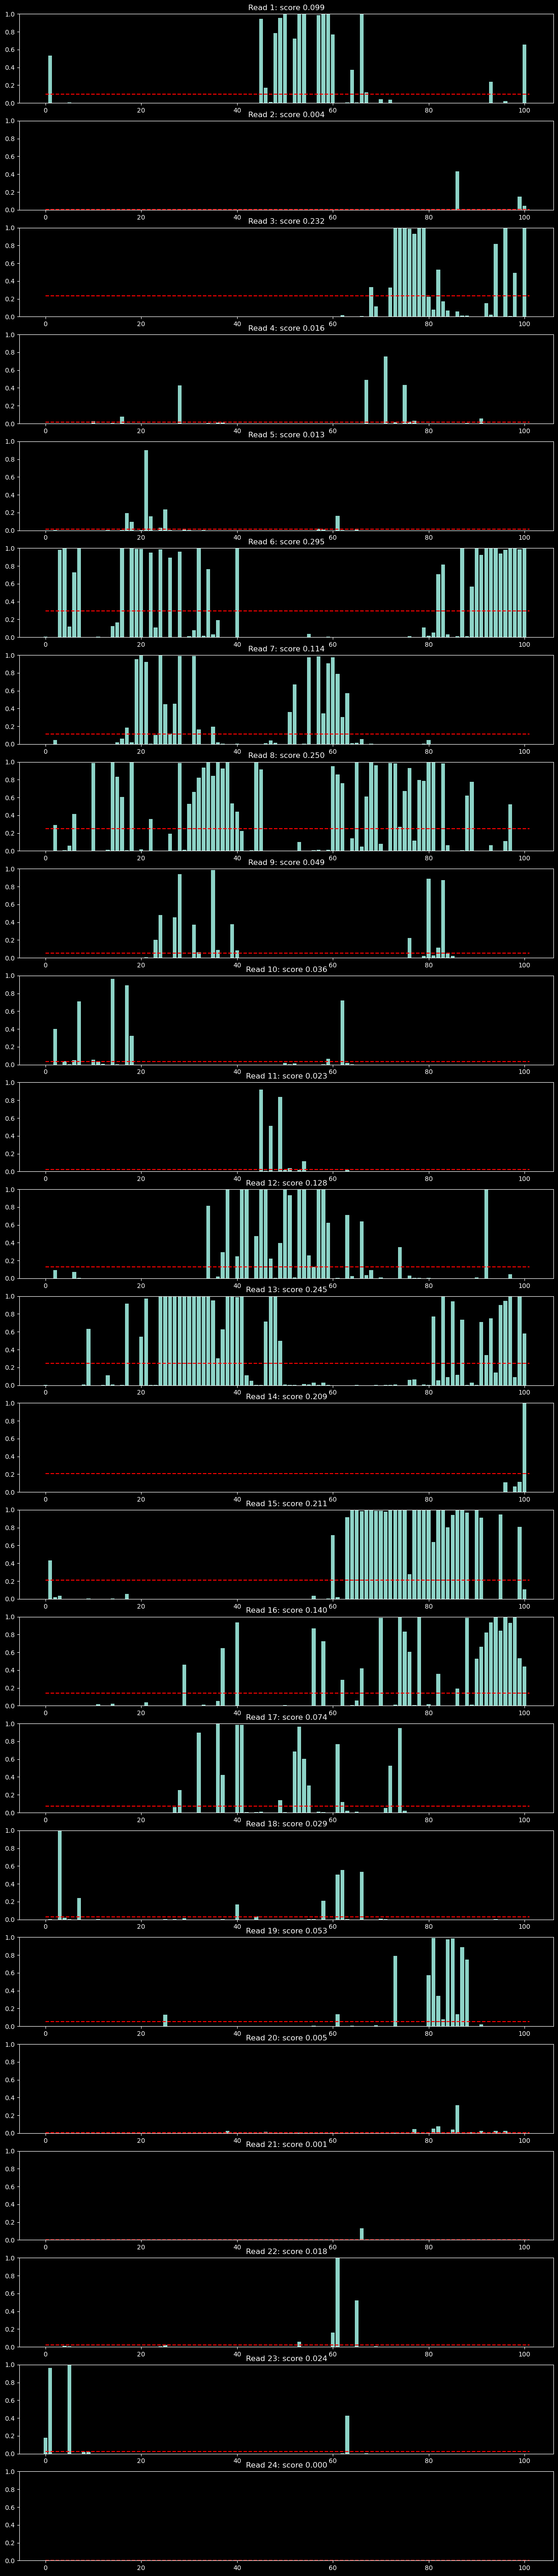

In [ ]:
# probs_scores = probabilities_scores(label_probs_kmer)
b = probs_scores.shape[0]
fig, axs = plt.subplots(nrows=b, ncols=1, figsize=(15,b*3))
true_label_probs = label_probs_kmer[:, :, true_label]
nb_50mer = k - 49
for i, ax in enumerate(axs.flatten()):
    ax.bar(x=range(nb_50mer),height=true_label_probs[i].numpy())
    ax.hlines(y=probs_scores[i].numpy(), xmin=0, xmax=nb_50mer, color='r', linestyle='--')
    ax.set_title(f"Read {i+1}: score {probs_scores[i].numpy():.3f}")
    ax.set_ylim(0,1)
plt.show()

# End of Section